## Problem Statement

**Goal**: <br>
Design book recommendation system by several methods and explore the strengths and weaknesses of each method.

**Research Question**: 
1. How can we calculate the similarity between books based on their content? How can we apply it to a recommendation system?
2. How can we predict the rating that a user will give to books that they haven't read? How can we apply it to a recommendation system?
3. What are the strengths and weakness of each method? How to overcome tht weakness?

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy import stats 


## Import Dataset

In this project, we will use Goodreads dataset. The dataset was originally scraped from the Goodreads API in September 2017 by Zygmunt Zając and updated by Olivier Simard-Hanley. This dataset consist of 5 files which are:
- ratings.csv: contains user ratings for books they read
- books_enriched.csv: contains metadata for each book (book ID, title, authors, year published, etc)
- to-read.csv: contains books marked "to read" by users
- book_tag.csv: contains tags/shelves/genres assigned by users to books
- tag.csv: contains the tag names corresponding to the tag ids in book_tag.csv

I will only use two files which are user ratings and metadata of the books.

In [2]:
r = pd.read_csv('data/ratings.csv')
b = pd.read_csv('data/books_enriched.csv')

# Data Exploration 

In [3]:
r.head(5)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In **dataset r**, there are three columns, which are:
1. `user_id`: user identification number
2. `book_id`: book identification number
3. `rating`: rating given by `user_id`

In [4]:
r.shape

(5976479, 3)

In [5]:
print(r["book_id"].nunique())
print(r["rating"].nunique())
print(r["user_id"].nunique())

print(r["book_id"].unique())
print(r["rating"].unique())
print(r["user_id"].unique())

10000
5
53424
[ 258 4081  260 ... 9580 8892 9548]
[5 4 3 2 1]
[    1     2     4 ... 27329 33111 49802]


There are 5,976,479 ratings given by 53,424 people on 10,000 books. Rating varies between 1-5. 

In [6]:
r.dtypes

user_id    int64
book_id    int64
rating     int64
dtype: object

In [7]:
b.shape

(10000, 30)

It has 10000 rows and 30 columns. We want to display values in all columns, therefore we will transpose the table and only show first three rows.

In [8]:
b.head(3).T

,0,1,2
Unnamed: 0,0,1,2
index,0,1,2
authors,['Suzanne Collins'],"['J.K. Rowling', 'Mary GrandPré']",['Stephenie Meyer']
average_rating,4.34,4.44,3.57
best_book_id,2767052,3,41865
book_id,1,2,3
books_count,272,491,226
description,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,Harry Potter's life is miserable. His parents ...,About three things I was absolutely positive.\...
genres,"['young-adult', 'fiction', 'fantasy', 'science...","['fantasy', 'fiction', 'young-adult', 'classics']","['young-adult', 'fantasy', 'romance', 'fiction..."
goodreads_book_id,2767052,3,41865


In this dataset, there are 30 columns. However, after investigating them, there are several columns that are repeated. For example too many book_id columns, 2 title columns, 2 authors column, details of the number of reviews per rating for each book, etc. In order to make cleaner metadata, I will do data preprocessing.

**Columns in dataset b**:<br>
- Identification number related (`book_id`, `goodreads_book_id`, `best_book_id`, `work_id`, `isbn`, `isbn13`)
- Title related (`original_title`, `title`)
- Authors related (`authors`, `authors_2`)
- Publication year related (`original_publication_year`, `publishDate`: the publication date)
- Rating related (`average_rating`, `ratings_count`: number of review, `work_ratings_count`, `work_text_reviews_count`, `ratings_1`, `ratings_2`, `ratings_3`, `ratings_4`, `ratings_5`)
- Image Url (`image_url`, `small_image_url`)
- `books_count`: number of edition available
- `language_code`: abbreviated language tags for all books
- `genres`: the genre tags taken from the top shelves users have assigned to a book. Only the main Goodreads genres have been retained
- `pages`: the total page count
- `description`: a free text summarizing the book's content
- Others (`Unnamed: 0`, `index`)

## Statistical summary

Before we decide which columns we will choose, let's explore the columns first. To make it easier, we can divide the columns to numerical columns and categorical columns and then check the statistics of our data.

In [9]:
nums = b.select_dtypes(include=[np.number]).columns
cats = b.select_dtypes(exclude=[np.number]).columns
print(nums)
print(cats)

Index(['Unnamed: 0', 'index', 'average_rating', 'best_book_id', 'book_id',
       'books_count', 'goodreads_book_id', 'isbn13',
       'original_publication_year', 'pages', 'ratings_1', 'ratings_2',
       'ratings_3', 'ratings_4', 'ratings_5', 'ratings_count', 'work_id',
       'work_ratings_count', 'work_text_reviews_count'],
      dtype='object')
Index(['authors', 'description', 'genres', 'image_url', 'isbn',
       'language_code', 'original_title', 'publishDate', 'small_image_url',
       'title', 'authors_2'],
      dtype='object')


In [10]:
b[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,10000.0,4.999500e+03,2.886896e+03,0.000000e+00,2.499750e+03,4.999500e+03,7.499250e+03,9.999000e+03
index,10000.0,4.526324e+03,2.567924e+03,0.000000e+00,2.351750e+03,4.567500e+03,6.661250e+03,9.999000e+03
average_rating,10000.0,4.002191e+00,2.544275e-01,2.470000e+00,3.850000e+00,4.020000e+00,4.180000e+00,4.820000e+00
best_book_id,10000.0,5.471214e+06,7.827330e+06,1.000000e+00,4.791175e+04,4.251235e+05,9.636112e+06,3.553423e+07
book_id,10000.0,5.000500e+03,2.886896e+03,1.000000e+00,2.500750e+03,5.000500e+03,7.500250e+03,1.000000e+04
books_count,10000.0,7.571270e+01,1.704707e+02,1.000000e+00,2.300000e+01,4.000000e+01,6.700000e+01,3.455000e+03
goodreads_book_id,10000.0,5.264697e+06,7.575462e+06,1.000000e+00,4.627575e+04,3.949655e+05,9.382225e+06,3.328864e+07
isbn13,9415.0,9.755044e+12,4.428619e+11,1.951703e+08,9.780316e+12,9.780452e+12,9.780831e+12,9.790008e+12
original_publication_year,9979.0,1.981988e+03,1.525767e+02,-1.750000e+03,1.990000e+03,2.004000e+03,2.011000e+03,2.017000e+03
pages,9927.0,3.594198e+02,2.169499e+02,0.000000e+00,2.500000e+02,3.360000e+02,4.240000e+02,5.216000e+03


- There are many unique columns: `Unnamed: 0`, `index`, `best_book_id`, `book_id`, `goodreads_book_id`, `isbn13`, `work_id`. The column `book_id` will be used to merge to rating table, so the other columns will be dropped.

- The oldest book was written in -1750 which means 1750 BC.
- Mean of `average_rating` is 4.002 (pretty good!)
- We found weird number of pages (0), we found that book should have at least 80 pages to be published
- The most popular book has 4,780,653 reviews, the least popular has 2,716 reviews.

In [11]:
b[cats].describe().T

,count,unique,top,freq
authors,10000,5057,['Stephen King'],58
description,9943,9772,The first in a spectacularly genre-mashing adv...,4
genres,10000,4351,"['fantasy', 'fiction']",152
image_url,10000,6669,https://s.gr-assets.com/assets/nophoto/book/11...,3332
isbn,9300,9300,439023483,1
language_code,10000,41,eng,9680
original_title,9415,9274,,5
publishDate,9992,4679,"(None, None, None)",75
small_image_url,10000,6669,https://s.gr-assets.com/assets/nophoto/book/50...,3332
title,10000,9964,Selected Poems,4


- The most popular author is Stephen King
- Selected Poems appears 4 times. Is it the same book?
- Because we already has `original_publication_year`, `publishDate` will be dropped
- `authors`, `genres`, `publishDate`, and `authors_2` has unnecessary characters

Now, let's select numerical columns that are not unique value columns.

In [12]:
not_unique_nums = ['average_rating', 'books_count', 'original_publication_year', 'pages', 
                    'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'ratings_count', 
                    'work_ratings_count', 'work_text_reviews_count']

## Univariate Analysis

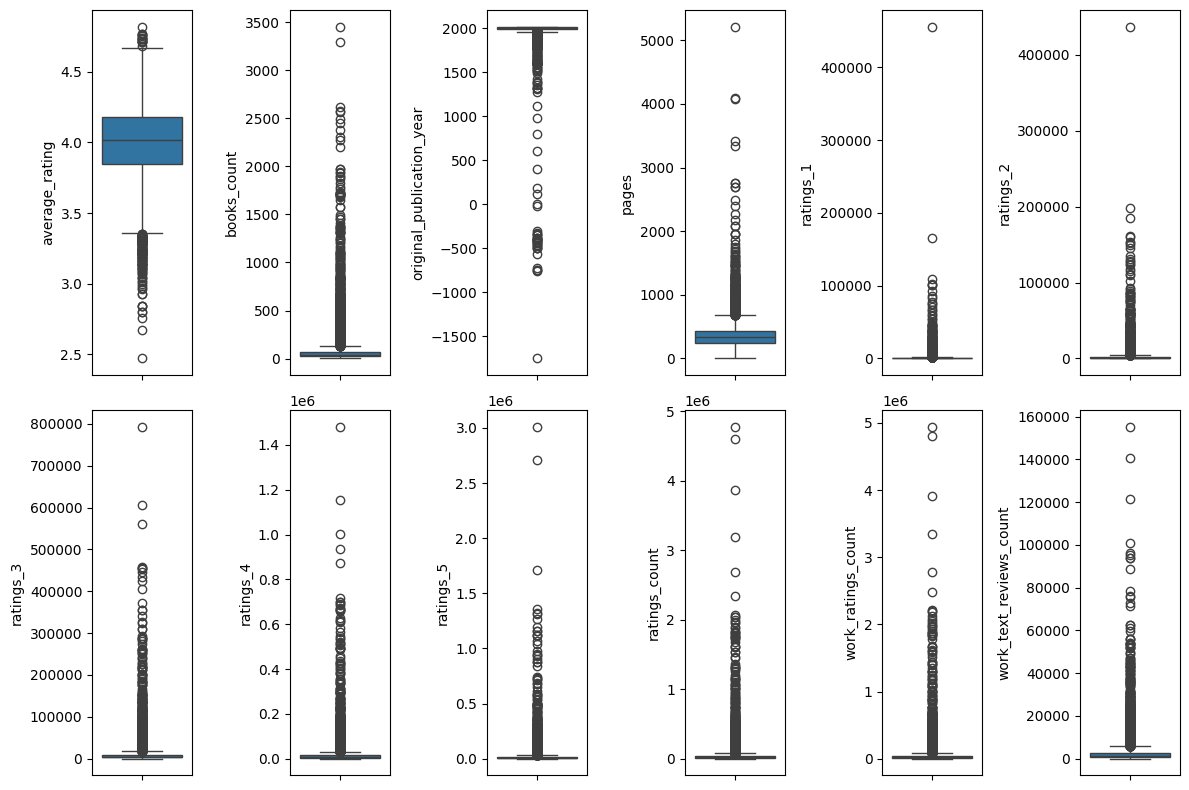

In [13]:
plt.figure(figsize=(12,8))

features = not_unique_nums
for i in range(0, len(features)):
    plt.subplot(2,6,i+1)
    sns.boxplot(y=b[features[i]])
    plt.tight_layout()

The data varies greatly, so there is no need to clean the outliers. 

## Bivariate Analysis

Now, let's check the correlation between columns.

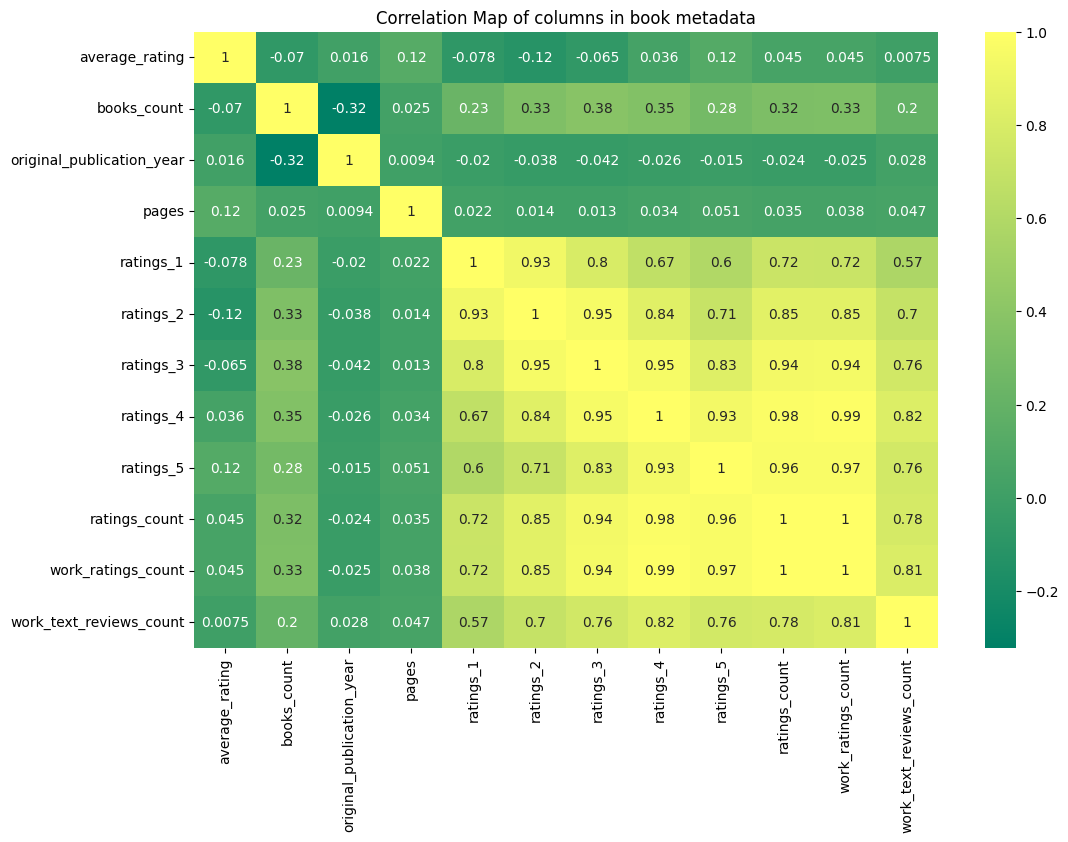

In [14]:
corr = b[not_unique_nums].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="summer", annot= True)
plt.title("Correlation Map of columns in book metadata")
plt.show()

- There is multicollinearity between ratings related columns. We can also see that the higher ratings show higher correlation to `work_ratings_count` and `work_text_reviews_count`. People tend to leave reviews for books they like. I will only use `ratings_count`.
- There is a high correlation between `original_publication_year` and `books_count`. It makes sense since the older book probably has been printed more and translated to many languages.

## Data Preprocessing


Our next step is data preprocessing. In building machine learning models, we should check for missing values and duplicated rows in our data. In this process we should also transform data into a format that is easier and more effective to process, so that our model will produce more accurate results.

In [15]:
b.isnull().sum()

Unnamed: 0                     0
index                          0
authors                        0
average_rating                 0
best_book_id                   0
book_id                        0
books_count                    0
description                   57
genres                         0
goodreads_book_id              0
image_url                      0
isbn                         700
isbn13                       585
language_code                  0
original_publication_year     21
original_title               585
pages                         73
publishDate                    8
ratings_1                      0
ratings_2                      0
ratings_3                      0
ratings_4                      0
ratings_5                      0
ratings_count                  0
small_image_url                0
title                          0
work_id                        0
work_ratings_count             0
work_text_reviews_count        0
authors_2                      0
dtype: int

In [16]:
r.isnull().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [17]:
percent_missing = b.isnull().sum() *100 /len(b)
missing_value = (pd.DataFrame({'percent_missing': percent_missing}).sort_values(by =['percent_missing'], ascending=False))
missing_value[missing_value['percent_missing']>0]
print(missing_value)

                           percent_missing
isbn                                  7.00
original_title                        5.85
isbn13                                5.85
pages                                 0.73
description                           0.57
original_publication_year             0.21
publishDate                           0.08
small_image_url                       0.00
ratings_count                         0.00
ratings_1                             0.00
ratings_4                             0.00
title                                 0.00
work_id                               0.00
ratings_3                             0.00
work_ratings_count                    0.00
ratings_2                             0.00
work_text_reviews_count               0.00
ratings_5                             0.00
Unnamed: 0                            0.00
index                                 0.00
language_code                         0.00
image_url                             0.00
goodreads_b

- Impute `original_publication_year` by using `publishDate`, then drop `publishDate`. I chose `original_publication_year` because it has the same format meanwhile `publishDate` has various data styles.
- Impute `pages` with median.
- Impute `description` with book's title
- Drop `isbn`, `original_title`, `isbn13`, there is no need to impute these columns.

In [18]:
b[b['original_publication_year'].isnull()][['original_publication_year', 'publishDate']]

,original_publication_year,publishDate
198,NaN,October 28th 2008
3249,NaN,February 7th 2006
3881,NaN,September 29th 2009
4252,NaN,November 10th 2010
4303,NaN,June 23rd 2009
4392,NaN,April 8th 2013
5001,NaN,November 9th 2004
5208,NaN,December 6th 2010
5648,NaN,October 11th 2006
7163,NaN,November 25th 2004


Lucky that all rows that are invalid in `original_publication_year` has the year in `publishDate`. Therefore, we can get year in `publishDate` and impute it to `original_publication_year`.

In [19]:
b["description"]= b["description"].fillna(b["title"])

In [20]:
b["pages"]= b["pages"].fillna(b["pages"].median())

In [21]:
b["publishDate"].replace(r"[(')]", "", regex=True, inplace=True)
b['publishDate'] = b['publishDate'].str.extract('(\d{4})$').fillna('')
b['original_publication_year'] = b['original_publication_year'].fillna(b['publishDate'])


In [22]:
b.drop(["isbn", "original_title", "isbn13", "publishDate"], axis=1, inplace=True)

## Feature Engineering

In [24]:
cols_keep = ["book_id", "title", "authors", "original_publication_year","pages", "description", "genres", "average_rating", "ratings_count", "books_count" ]
b=b[cols_keep]

Now, let's check the value in each columns. In order to find any strange characters, we need to display column width to maximum. 

In [27]:
with pd.option_context('display.max_colwidth', None):
    display(b.head(5))

,book_id,title,authors,original_publication_year,pages,description,genres,average_rating,ratings_count,books_count
0,1,"The Hunger Games (The Hunger Games, #1)",['Suzanne Collins'],2008.0,374.0,"WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH.THE HUNGER GAMES HAVE BEGUN. . . .In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV.Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against love.","['young-adult', 'fiction', 'fantasy', 'science-fiction', 'romance']",4.34,4780653,272
1,2,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)","['J.K. Rowling', 'Mary GrandPré']",1997.0,309.0,"Harry Potter's life is miserable. His parents are dead and he's stuck with his heartless relatives, who force him to live in a tiny closet under the stairs. But his fortune changes when he receives a letter that tells him the truth about himself: he's a wizard. A mysterious visitor rescues him from his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry.After a lifetime of bottling up his magical powers, Harry finally feels like a normal kid. But even within the Wizarding community, he is special. He is the boy who lived: the only person to have ever survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the Wizarding world, only to vanish after failing to kill Harry.Though Harry's first year at Hogwarts is the best of his life, not everything is perfect. There is a dangerous secret object hidden within the castle walls, and Harry believes it's his responsibility to prevent it from falling into evil hands. But doing so will bring him into contact with forces more terrifying than he ever could have imagined.Full of sympathetic characters, wildly imaginative situations, and countless exciting details, the first installment in the series assembles an unforgettable magical world and sets the stage for many high-stakes adventures to come.","['fantasy', 'fiction', 'young-adult', 'classics']",4.44,4602479,491
2,3,"Twilight (Twilight, #1)",['Stephenie Meyer'],2005.0,501.0,"About three things I was absolutely positive.\n\nFirst, Edward was a vampire.\n\nSecond, there was a part of him—and I didn't know how dominant that part might be—that thirsted for my blood.\n\nAnd third, I was unconditionally and irrevocably in love with him.\n\nDeeply seductive and extraordinarily suspenseful, Twilight is a love story with bite.","['young-adult', 'fantasy', 'romance', 'fiction', 'paranormal']",3.57,3866839,226
3,4,To Kill a Mockingbird,['Harper Lee'],1960.0,324.0,"The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it, To Kill A Mockingbird became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.Compassionate, dramatic, and deeply moving, To Kill A Mockingbird takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copies in print and translated into forty languages, this regional story by a young Alabama woman claims universal appeal. Harper Lee always considered her book to be a simple love story. Today it is regarded as a masterpiece of American literatur

In our top 5 entry, we found unnecessary characters that are not supposed to be in `description` column. We need to delete that unnecessary characters in order to make better result in finding similar books. It is actually time consuming to check it one by one, but we tried our best to capture all unnecessary characters and try to guess the rest. And then we delete that unnecessary characters and make all fonts lowercase.

In [29]:
#delete unnecessary characters from authors, genres and description column
col_trans = ['authors', 'genres', 'description']
for col in col_trans:
    b[col].replace(r"[\[\]\-\\\/\"—'()|:]", "", regex=True, inplace=True) 
b['description'].replace({"\n" : " ", "isbn13" : "", "isbn" : "", r"[0-9]{8,}" : "", r"[.,]" : ""}, regex=True, inplace=True)
b['description'] = b['description'].str.lower()

In [30]:
b.rename(columns={'original_publication_year':'year'}, inplace=True)
b[['year', 'pages', 'books_count']] = b[['year', 'pages', 'books_count']].astype(int)

We try to check 5 samples. If they are looking good (there are no unnecessary characters anymore) then we are good to go!

In [32]:
with pd.option_context('display.max_colwidth', None):
    display(b.head(5))

,book_id,title,authors,year,pages,description,genres,average_rating,ratings_count,books_count
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008,374,winning means fame and fortunelosing means certain deaththe hunger games have begun in the ruins of a place once known as north america lies the nation of panem a shining capitol surrounded by twelve outlying districts the capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual hunger games a fight to the death on live tvsixteenyearold katniss everdeen regards it as a death sentence when she steps forward to take her sisters place in the games but katniss has been close to dead beforeand survival for her is second nature without really meaning to she becomes a contender but if she is to win she will have to start making choices that weight survival against humanity and life against love,"youngadult, fiction, fantasy, sciencefiction, romance",4.34,4780653,272
1,2,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)","J.K. Rowling, Mary GrandPré",1997,309,harry potters life is miserable his parents are dead and hes stuck with his heartless relatives who force him to live in a tiny closet under the stairs but his fortune changes when he receives a letter that tells him the truth about himself hes a wizard a mysterious visitor rescues him from his relatives and takes him to his new home hogwarts school of witchcraft and wizardryafter a lifetime of bottling up his magical powers harry finally feels like a normal kid but even within the wizarding community he is special he is the boy who lived the only person to have ever survived a killing curse inflicted by the evil lord voldemort who launched a brutal takeover of the wizarding world only to vanish after failing to kill harrythough harrys first year at hogwarts is the best of his life not everything is perfect there is a dangerous secret object hidden within the castle walls and harry believes its his responsibility to prevent it from falling into evil hands but doing so will bring him into contact with forces more terrifying than he ever could have imaginedfull of sympathetic characters wildly imaginative situations and countless exciting details the first installment in the series assembles an unforgettable magical world and sets the stage for many highstakes adventures to come,"fantasy, fiction, youngadult, classics",4.44,4602479,491
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,2005,501,about three things i was absolutely positive first edward was a vampire second there was a part of himand i didnt know how dominant that part might bethat thirsted for my blood and third i was unconditionally and irrevocably in love with him deeply seductive and extraordinarily suspenseful twilight is a love story with bite,"youngadult, fantasy, romance, fiction, paranormal",3.57,3866839,226
3,4,To Kill a Mockingbird,Harper Lee,1960,324,the unforgettable novel of a childhood in a sleepy southern town and the crisis of conscience that rocked it to kill a mockingbird became both an instant bestseller and a critical success when it was first published in 1960 it went on to win the pulitzer prize in 1961 and was later made into an academy awardwinning film also a classiccompassionate dramatic and deeply moving to kill a mockingbird takes readers to the roots of human behavior to innocence and experience kindness and cruelty love and hatred humor and pathos now with over 18 million copies in print and translated into forty languages this regional story by a young alabama woman claims universal appeal harper lee always considered her book to be a simple love story today it is regarded as a masterpiece of american literature,"classics, fiction, historicalfiction, youngadult",4.25,3198671,487
4,5,The Great Gatsby,F. Scott Fitzgerald,1925,200,alternate cover edition isbn isbn13 the great gatsby f scott fitzgeralds th

In [33]:
b.columns

Index(['book_id', 'title', 'authors', 'year', 'pages', 'description', 'genres',
       'average_rating', 'ratings_count', 'books_count'],
      dtype='object')

# EDA Questions

### 1. How is the rating for all books distributed?

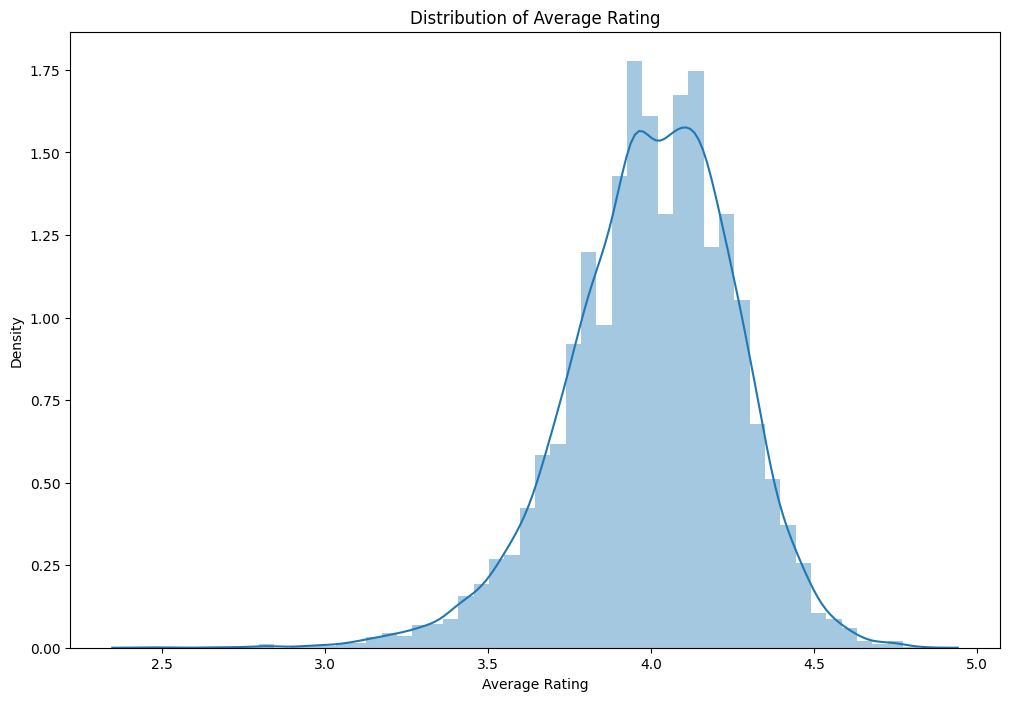

In [34]:
plt.figure(figsize=(12,8))
sns.distplot(b["average_rating"])
plt.title("Distribution of Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Density")
plt.show()

In [35]:
b.describe()

,book_id,year,pages,average_rating,ratings_count,books_count
count,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,5000.50000,1982.040200,359.248800,4.002191,5.400124e+04,75.712700
std,2886.89568,152.420793,216.165717,0.254427,1.573700e+05,170.470728
min,1.00000,-1750.000000,0.000000,2.470000,2.716000e+03,1.000000
25%,2500.75000,1990.000000,251.000000,3.850000,1.356875e+04,23.000000
50%,5000.50000,2004.000000,336.000000,4.020000,2.115550e+04,40.000000
75%,7500.25000,2011.000000,422.000000,4.180000,4.105350e+04,67.000000
max,10000.00000,2017.000000,5216.000000,4.820000,4.780653e+06,3455.000000


Since this is a list of 10,000 popular books, we admit the fact that the majority of the books are good books with an average value of 4. 

### 2. How is the average rating per user distributed?

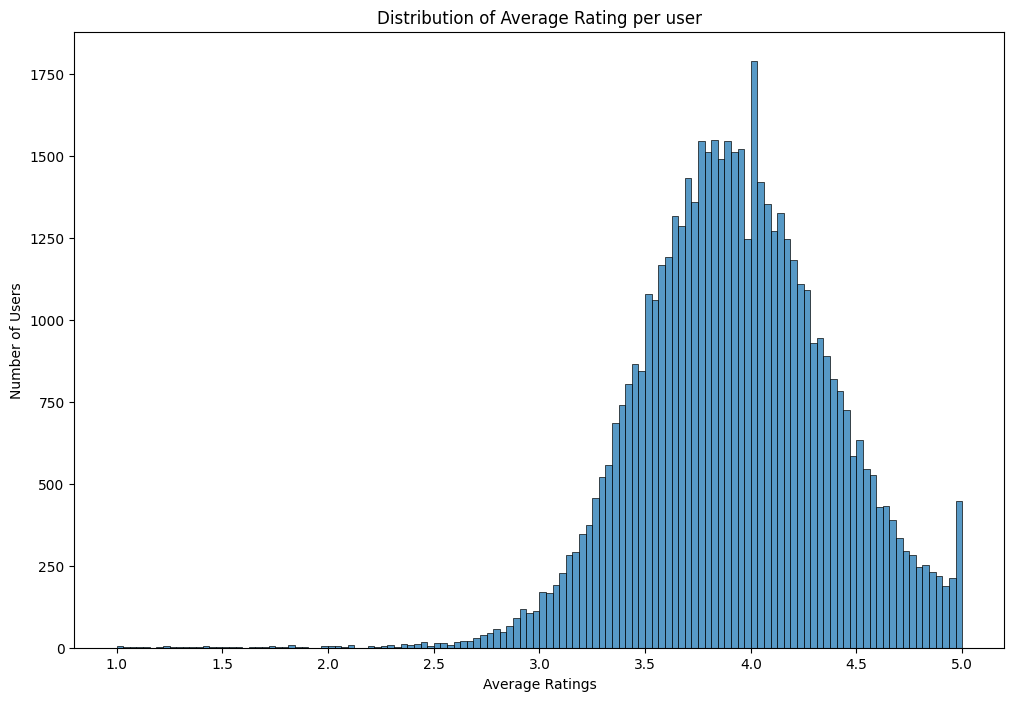

In [37]:
av_rating = r.groupby("user_id")["rating"].mean().reset_index()

plt.figure(figsize=(12,8))
sns.histplot(data=av_rating, x="rating")
plt.title("Distribution of Average Rating per user")
plt.xlabel("Average Ratings")
plt.ylabel("Number of Users")
plt.show()

### 3. How many ratings does a book usually get?

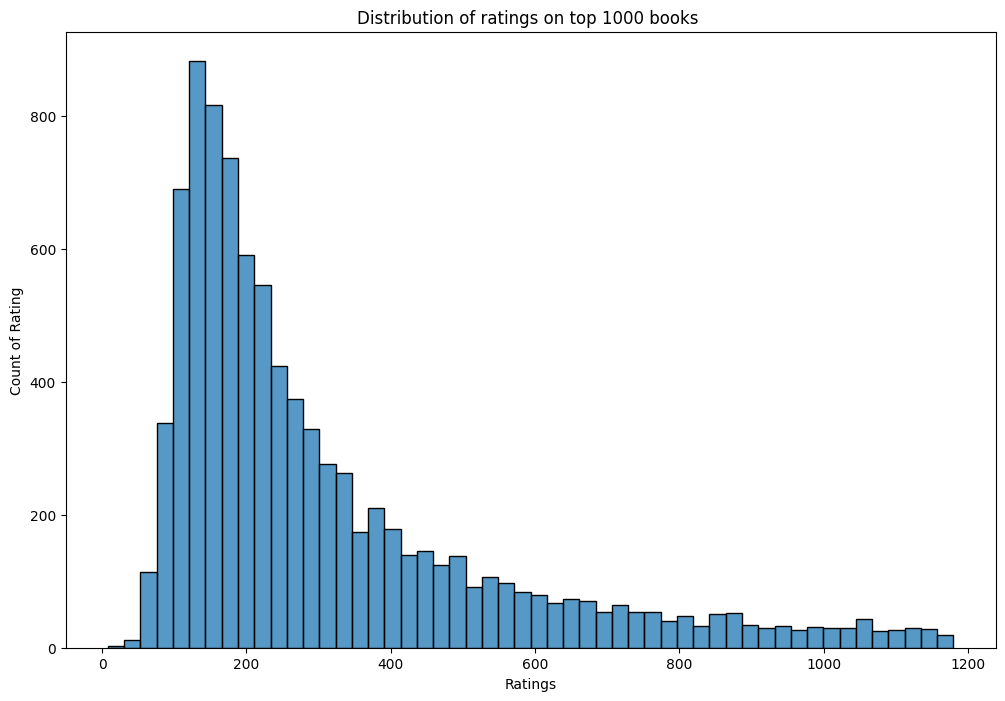

In [46]:
rating_per_book = r.groupby("book_id")["rating"].count().reset_index().sort_values(by = "rating")

plt.figure(figsize=(12,8))
sns.histplot(data = rating_per_book.head(9000), x = "rating")
plt.title("Distribution of ratings on top 1000 books ")
plt.xlabel("Ratings")
plt.ylabel("Count of Rating")
plt.show()

The distribution of reviews on books is positively skewed. There are more books that has less ratings. Let's check the number of rating distribution.

In [47]:
rating_per_book["rating"].describe()

count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: rating, dtype: float64

Books in this database have at least 8 reviews, while popular books have 22,806 reviews. The gap is too large. Now, let's check the outliers.

In [48]:
q3, q1 = np.percentile(rating_per_book, [75,25])
iqr = q3-q1
maximum = q3 +(1.5*iqr)
outlier_books = len(rating_per_book[rating_per_book["rating"]> maximum])
print(f"We have {outlier_books} books that are considered outlier because they have more than 1215 number of ratings ")

We have 26 books that are considered outlier because they have more than 1215 number of ratings 


I will not delete the outliers, to keep the data variety.

### 4. How many ratings does a user usually give?

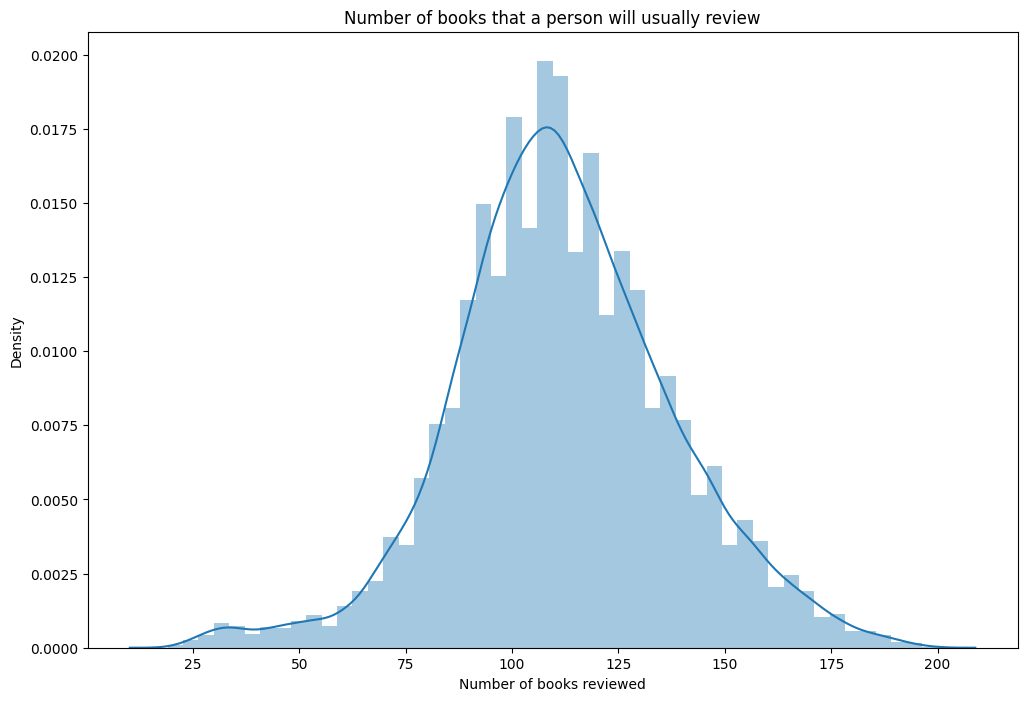

In [49]:
book_per_user = r.groupby("user_id")["rating"].count().reset_index()

plt.figure(figsize=(12,8))
sns.distplot(book_per_user["rating"])
plt.title("Number of books that a person will usually review")
plt.xlabel("Number of books reviewed")
plt.ylabel("Density")
plt.show()

In [50]:
book_per_user["rating"].describe()

count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
Name: rating, dtype: float64

At most people review 200 books and at least 19 books. The average person gives a review of 111 books.
From 10,000 books in our dataset, even the **user with the highest number of reviews** managed to give a rating to **only 2% of all of the books**. Data in user is very sparse, so it will be better to use item-based collaborative filtering.

### 5. Which book has the highest rating and which book has the most ratings?

In [51]:
books_sorted = b.sort_values("average_rating", ascending=False)
books_sorted.head(10)

,book_id,title,authors,year,pages,description,genres,average_rating,ratings_count,books_count
3353,3628,The Complete Calvin and Hobbes,Bill Watterson,2005,1456,box set book one book two book three c...,"comics, graphicnovels, fiction, classics",4.82,28900,14
3043,3275,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",2003,2690,box set containing harry potter and the sorcer...,"fantasy, youngadult, fiction, classics",4.77,33220,11
810,862,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,2014,1087,words of radiance book two of the stormlight a...,"fantasy, fiction",4.77,73572,34
6779,7947,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",2002,2750,the esv study bible was designed to help you u...,"christian, nonfiction, religion, classics, his...",4.76,8953,96
7403,8854,Mark of the Lion Trilogy,Francine Rivers,1993,1468,this bestselling trilogy chronicles a tale of ...,"christian, historicalfiction, fiction, romance...",4.76,9081,6
4068,4483,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,1996,176,when cartoonist bill watterson announced that ...,"comics, graphicnovels, fiction",4.75,22351,21
387,422,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,1998,4100,over 4000 pages of harry potter and his world ...,"fantasy, youngadult, fiction, classics",4.74,190050,76
5593,6361,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,1996,176,in the world that calvin and his stuffed tiger...,"comics, fiction, graphicnovels",4.74,16766,22
5767,6590,The Authoritative Calvin and Hobbes: A Calvin ...,Bill Watterson,1990,254,a collection of calvin and hobbes cartoons the...,"comics, graphicnovels, fiction, classics",4.73,16087,21
3457,3753,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,2005,3342,six years of magic adventure and mystery make ...,"fantasy, fiction, youngadult, classics",4.73,24618,6


In [52]:
books_count = b.sort_values("ratings_count", ascending=False)
books_count.head(10)

,book_id,title,authors,year,pages,description,genres,average_rating,ratings_count,books_count
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008,374,winning means fame and fortunelosing means cer...,"youngadult, fiction, fantasy, sciencefiction, ...",4.34,4780653,272
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",1997,309,harry potters life is miserable his parents ar...,"fantasy, fiction, youngadult, classics",4.44,4602479,491
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,2005,501,about three things i was absolutely positive ...,"youngadult, fantasy, romance, fiction, paranormal",3.57,3866839,226
3,4,To Kill a Mockingbird,Harper Lee,1960,324,the unforgettable novel of a childhood in a sl...,"classics, fiction, historicalfiction, youngadult",4.25,3198671,487
4,5,The Great Gatsby,F. Scott Fitzgerald,1925,200,alternate cover edition isbn isbn13 the great...,"classics, fiction, historicalfiction, romance",3.89,2683664,1356
5,6,The Fault in Our Stars,John Green,2012,313,despite the tumorshrinking medical miracle tha...,"youngadult, romance, fiction, contemporary",4.26,2346404,226
6,7,The Hobbit,J.R.R. Tolkien,1937,366,in a hole in the ground there lived a hobbit n...,"fantasy, classics, fiction, youngadult",4.25,2071616,969
7,8,The Catcher in the Rye,J.D. Salinger,1951,277,the heronarrator of the catcher in the rye is ...,"classics, fiction, youngadult",3.79,2044241,360
9,10,Pride and Prejudice,Jane Austen,1813,279,alternate cover edition of isbn since its imme...,"classics, fiction, romance, historicalfiction",4.24,2035490,3455
8,9,"Angels & Demons (Robert Langdon, #1)",Dan Brown,2000,736,worldrenowned harvard symbologist robert langd...,"fiction, mystery, thriller, suspense, crime, h...",3.85,2001311,311


- When we sort book based on `ratings_count`, we found several books that have an `average_rating` lower than the mean (less than 4.002)
- When we sort book based on `average_rating`, we found several books lower number of reviews (`ratings_count`).
- Therefore we should make a new score calculation that also takes into account the `average_rating` and `ratings_count`.

### 6. How is the relationship between the number of ratings and the average rating?

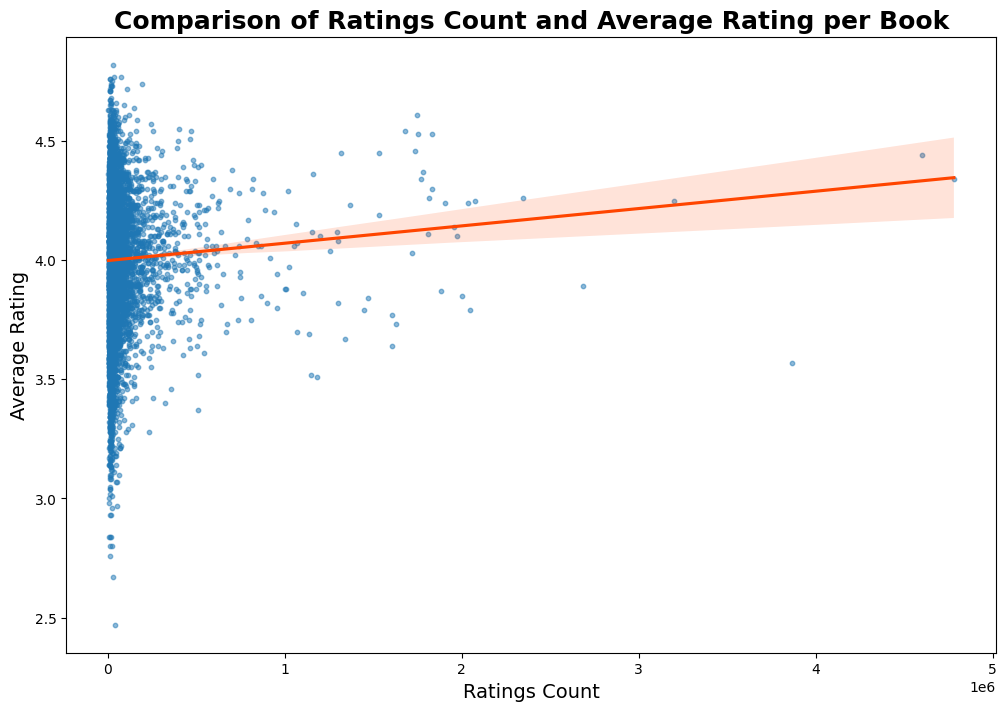

In [54]:
x = b['ratings_count']
y = b['average_rating']

plt.figure(figsize=(12, 8))
sns.regplot(x=x, y=y, scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'orangered'})
plt.title('Comparison of Ratings Count and Average Rating per Book', fontsize=18, weight='bold')
plt.xlabel('Ratings Count', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.show()

In [61]:
correlation = b[["ratings_count", "average_rating"]]
corr = correlation.corr()
print(corr)

                ratings_count  average_rating
ratings_count         1.00000         0.04499
average_rating        0.04499         1.00000


A book that is popular (has lots of ratings) is more likely to get a good rating. However, if we look at our data, the correlation between `average_rating` and `ratings_count` is not too big, which means that many popular books have low ratings.

### 7. Who is the author with most books?

In [63]:
#First try with the simple count
author_book_count = b.groupby('authors')['title'].count().sort_values(ascending = False)
author_book_count.head()

authors
Stephen King       60
Nora Roberts       59
Dean Koontz        46
Terry Pratchett    42
Agatha Christie    39
Name: title, dtype: int64

Based in simple count, author with most books is Stephen King. However, in fact there are books written by more than one author, right?. So let's check them.

In [64]:
auth = []
b.authors.apply(lambda x: auth.append(x) if 'Stephen King' in x else [])
print(auth)

['Stephen King', 'Stephen King, Bernie Wrightson', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King, Marie Milpois', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Richard Bachman, Stephen King', 'Stephen King, Ned Dameron', 'Stephen King', 'Stephen King', 'Stephen King, Dave McKean', 'Stephen King, William Olivier Desmond', 'Stephen King, John D. MacDonald', 'Stephen King', 'Stephen King, Bettina Blanch Tyroller', 'Stephen King, Bernie Wrightson', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King, Darrel Anderson', 'Stephen King, Dominique Dill', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King', 'Stephen King, Peter Straub', 'Stephen King', 'Richard Bachman, Stephen King', 'Stephen King, Jerry N. Uelsmann', 'Stephen King', 'Stephen King', '

Actually, there are several books written by more than one authors. These books are not included in the total books written by the author! I decided to pick only the first author to simplify our process.

In [65]:
a =[]
b.authors.apply(lambda x: a.append(x) if ',' in x else [])
print(a)

['J.K. Rowling, Mary GrandPré', 'Anne Frank, Eleanor Roosevelt, B.M. MooyaartDoubleday', 'Stieg Larsson, Reg Keeland', 'J.K. Rowling, Mary GrandPré, Rufus Beck', 'J.K. Rowling, Mary GrandPré', 'J.K. Rowling, Mary GrandPré', 'J.K. Rowling, Mary GrandPré', 'J.K. Rowling, Mary GrandPré', 'J.K. Rowling, Mary GrandPré', 'William Shakespeare, Robert           Jackson', 'Charlotte Brontë, Michael Mason', 'Mark Twain, John Seelye, Guy Cardwell', 'E.B. White, Garth Williams, Rosemary Wells', 'Emily Brontë, Richard J. Dunn', 'Jane Austen, Tony Tanner, Ros Ballaster', 'Louis Sachar, Louis Sachar', 'Homer, Robert Fagles, E.V. Rieu, Frédéric Mugler, Bernard Knox', 'Antoine de SaintExupéry, Richard Howard, Dom Marcos Barbosa, Melina Karakosta', 'Charles Dickens, Richard Maxwell, Hablot Knight Browne', 'Elie Wiesel, Marion Wiesel', 'Steven D. Levitt, Stephen J. Dubner', 'Gabriel García Márquez, Gregory Rabassa', 'Oscar Wilde, Jeffrey Eugenides', 'Bram Stoker, Nina Auerbach, David J. Skal', 'Stieg Lar

In [67]:
#insert splitted author list in every row
authors_list = b['authors'].apply(lambda x: [a for a in x.split(', ')] if ',' in x else x)
authors_list.head()

0                  Suzanne Collins
1    [J.K. Rowling, Mary GrandPré]
2                  Stephenie Meyer
3                       Harper Lee
4              F. Scott Fitzgerald
Name: authors, dtype: object

In [68]:
splitted_authors = authors_list.apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True)
splitted_authors.name = 'authors'
splitted_authors.head()

0    Suzanne Collins
1       J.K. Rowling
1      Mary GrandPré
2    Stephenie Meyer
3         Harper Lee
Name: authors, dtype: object

In [70]:
#remove previous author column and join the new splitted authors
b = b.drop('authors', axis=1).join(splitted_authors)

In [71]:
# Take the first author for each book and remove the rest
b= b.drop_duplicates(subset='book_id', keep='first')

In [72]:
#author with most books
book_count_real = b['authors'].value_counts()
book_count_real.head()

authors
James Patterson    96
Stephen King       80
Nora Roberts       63
Dean Koontz        51
Terry Pratchett    48
Name: count, dtype: int64

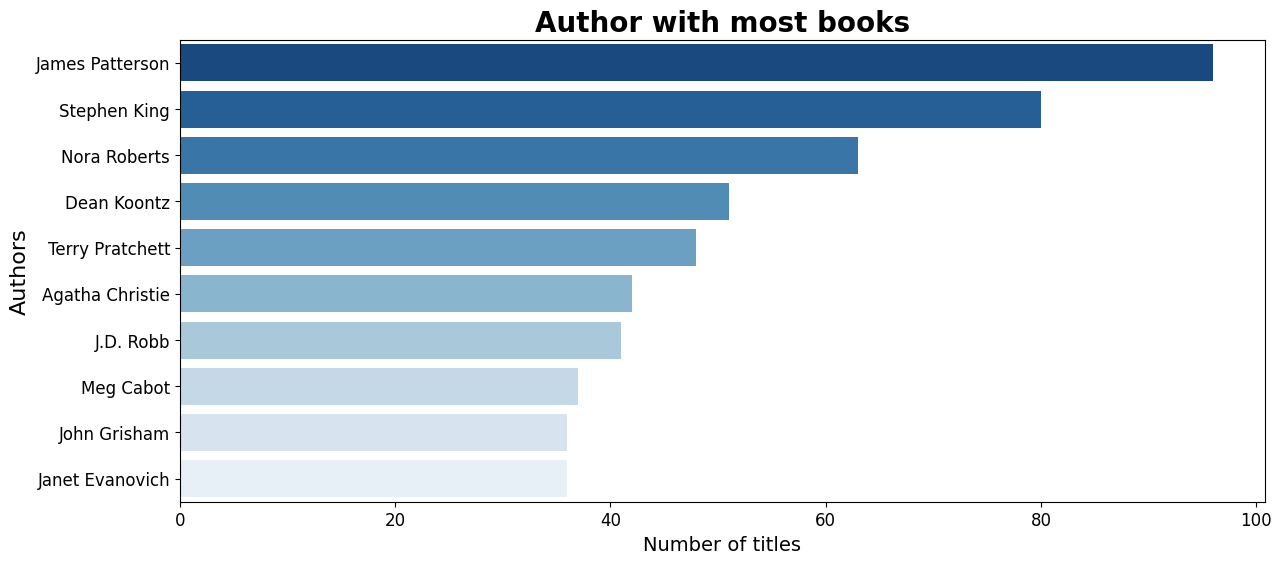

In [73]:
#visualize
plt.figure(figsize=(14,6))
sns.barplot(x=book_count_real.head(10).values, 
            y=book_count_real.head(10).index,
           palette = 'Blues_r')
plt.title('Author with most books', weight='bold', fontsize=20)
plt.xlabel('Number of titles', fontsize=14)
plt.ylabel('Authors', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### 8. Who is the most popular author?

In [74]:
popular_author = b.groupby("authors")["ratings_count"].sum().sort_values(ascending=False)
popular_author.head(5)

authors
J.K. Rowling       16036005
Suzanne Collins     8646393
Stephenie Meyer     8512437
Stephen King        8250167
J.R.R. Tolkien      5454844
Name: ratings_count, dtype: int64

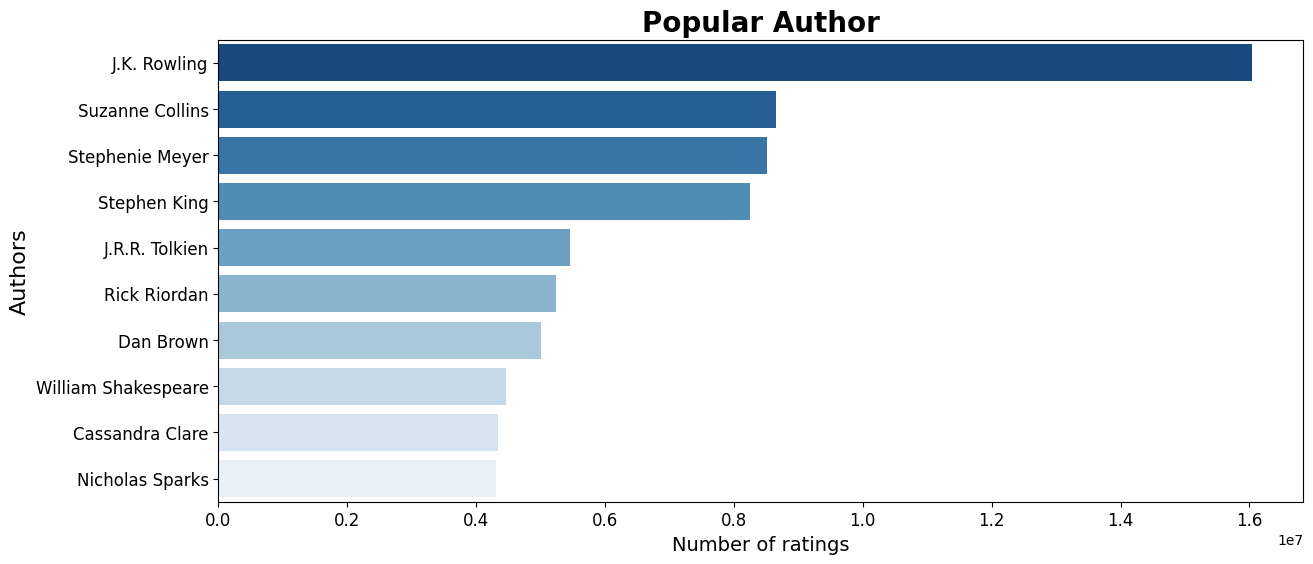

In [75]:
#visualize
plt.figure(figsize=(14,6))
sns.barplot(x=popular_author.head(10).values, 
            y=popular_author.head(10).index,
           palette = 'Blues_r')
plt.title('Popular Author', weight='bold', fontsize=20)
plt.xlabel('Number of ratings', fontsize=14)
plt.ylabel('Authors', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Even though James Patterson is the author with the most books, he is not the one who has the most ratings. We have J.K Rowling as the most ratings author with her 20 books in this dataset.

### 9. Who is the author that has good ratings book?

In [77]:
high_rating_author = b.groupby('authors')['average_rating'].mean().sort_values(ascending = False)
high_rating_author.head(5)

authors
Bill Watterson      4.703077
Hafez               4.630000
James E. Talmage    4.630000
Eiichiro Oda        4.630000
Angie Thomas        4.620000
Name: average_rating, dtype: float64

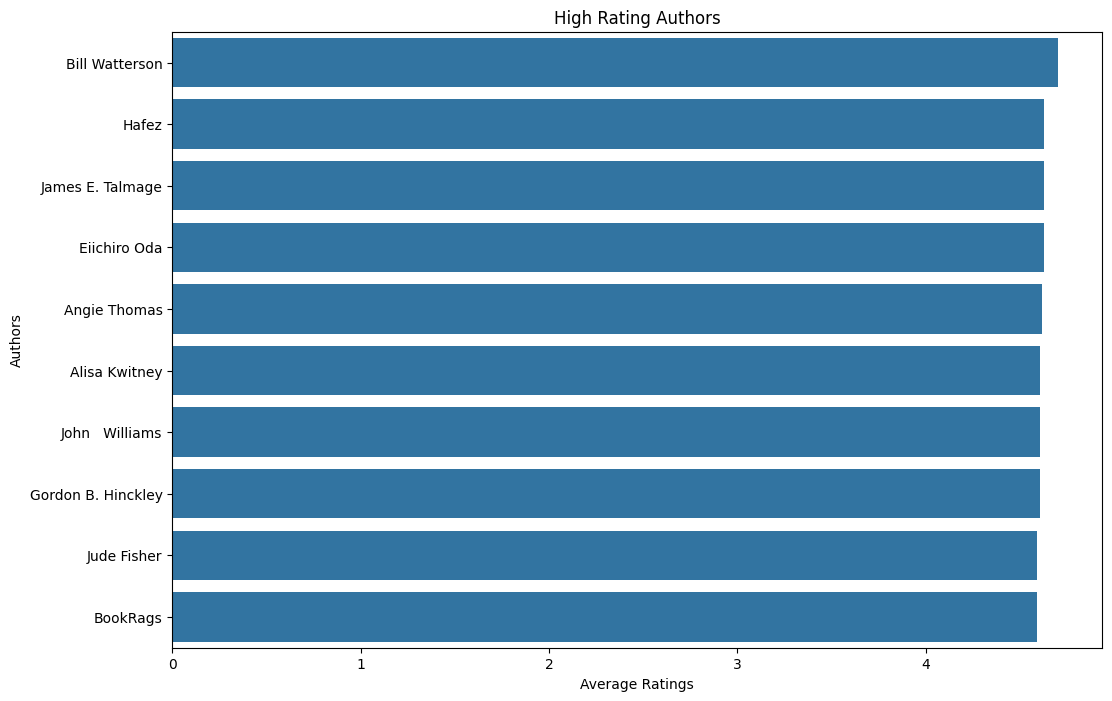

In [78]:
plt.figure(figsize=(12,8))
sns.barplot(x=high_rating_author.head(10).values,
            y=high_rating_author.head(10).index)
plt.title("High Rating Authors")
plt.xlabel("Average Ratings")
plt.ylabel("Authors")
plt.show()

Bill Watterson is the one with the highest rating. But as we can see, there isn't much of a difference between the authors average rating.

### 10. How is the relationship between the number of pages and the year the book was published?

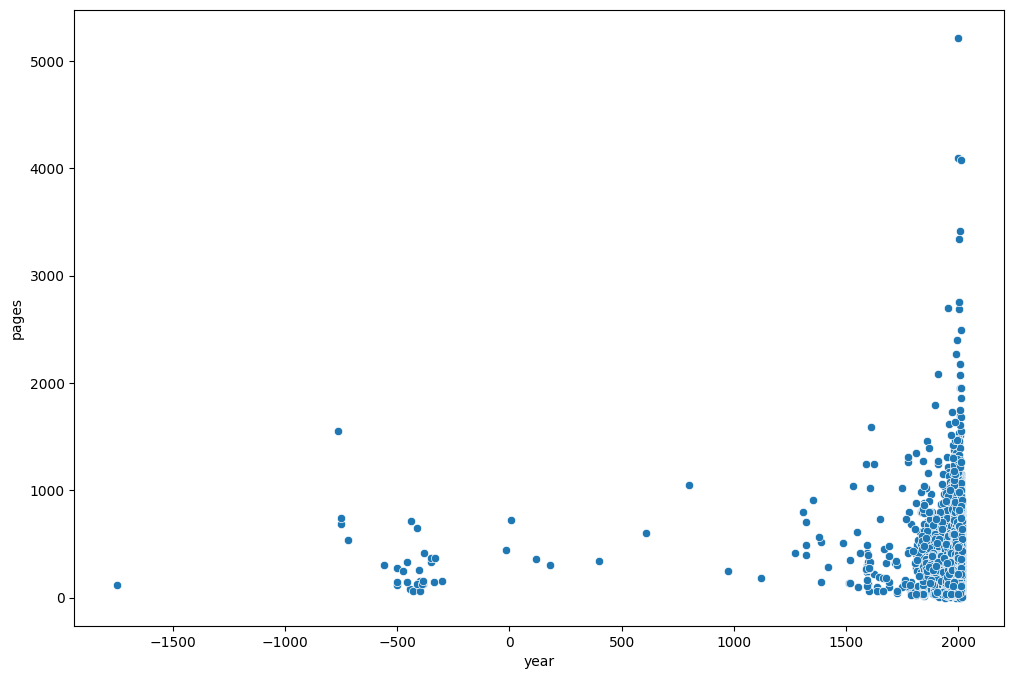

In [81]:
plt.figure(figsize=(12,8))
sns.scatterplot(y=b.pages, x=b.year)
plt.show()

The range of year of publication is too large, therefore we need to check when the entry is more dense.

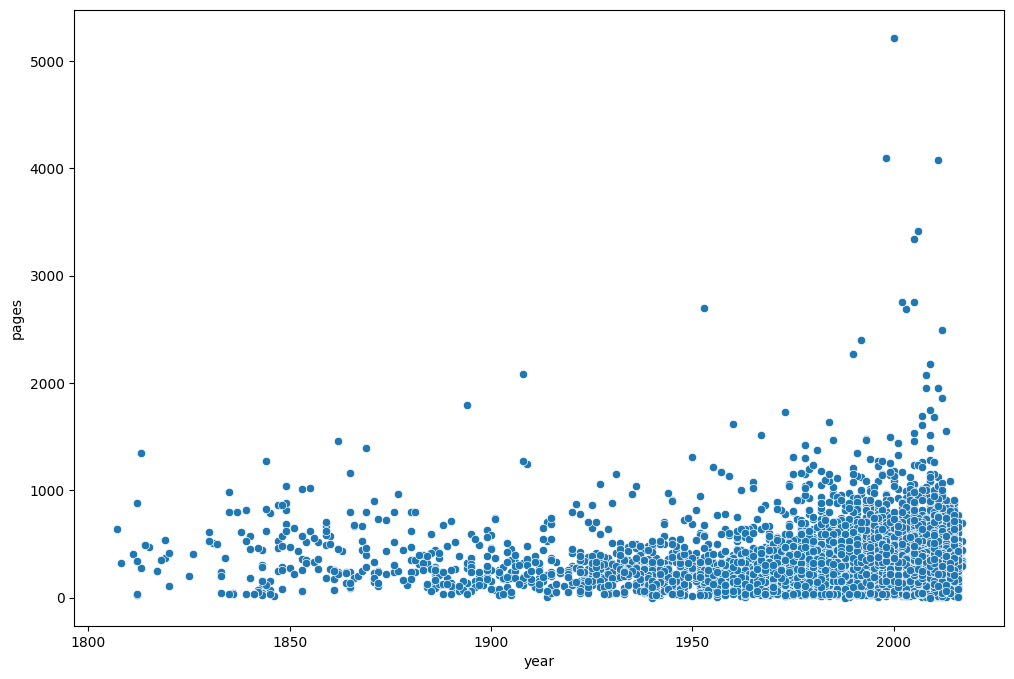

In [82]:
b1800 = b[b['year']>1800]

plt.figure(figsize=(12,8))
sns.scatterplot(x=b1800.year, y=b.pages)
plt.show()

- Before 1900, the number of pages was randomly distributed. There are books that have more than 1000 pages but also books that have less than 100 pages. We can see that after 1900 the distribution started to stable, but it is less than 500 pages. 
- After 1980, the trend also show slight increase. Most of recent books have around 400 pages.

### 11. What genre dominates the dataset?

In [83]:
g=[]
b.genres.apply(lambda x : g.append(x) if ',' in x else [])
print(g)

['youngadult, fiction, fantasy, sciencefiction, romance', 'fantasy, fiction, youngadult, classics', 'youngadult, fantasy, romance, fiction, paranormal', 'classics, fiction, historicalfiction, youngadult', 'classics, fiction, historicalfiction, romance', 'youngadult, romance, fiction, contemporary', 'fantasy, classics, fiction, youngadult', 'classics, fiction, youngadult', 'fiction, mystery, thriller, suspense, crime, historicalfiction', 'classics, fiction, romance, historicalfiction', 'fiction, historicalfiction, contemporary, classics', 'youngadult, fiction, fantasy, sciencefiction, romance', 'nonfiction, classics, history, biography, memoir', 'fiction, mystery, suspense, contemporary, thriller, crime', 'youngadult, fiction, fantasy, sciencefiction, romance', 'fantasy, youngadult, fiction, classics', 'youngadult, fiction, fantasy, sciencefiction, romance', 'fantasy, youngadult, fiction, classics', 'fiction, mystery, youngadult, contemporary, fantasy, crime', 'fantasy, youngadult, fict

In [84]:
#insert splitted author list in every row
genres_list = b['genres'].apply(lambda x: [g for g in x.split(', ')] if ',' in x else x)
genres_list.head()

0    [youngadult, fiction, fantasy, sciencefiction,...
1             [fantasy, fiction, youngadult, classics]
2    [youngadult, fantasy, romance, fiction, parano...
3    [classics, fiction, historicalfiction, youngad...
4      [classics, fiction, historicalfiction, romance]
Name: genres, dtype: object

In [85]:
splitted_genres = genres_list.apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True)
splitted_genres.name = 'genres'
splitted_genres.head()

0        youngadult
0           fiction
0           fantasy
0    sciencefiction
0           romance
Name: genres, dtype: object

In [86]:
#remove previous author column and join the new splitted authors
book_genres = b.drop('genres', axis=1).join(splitted_genres)

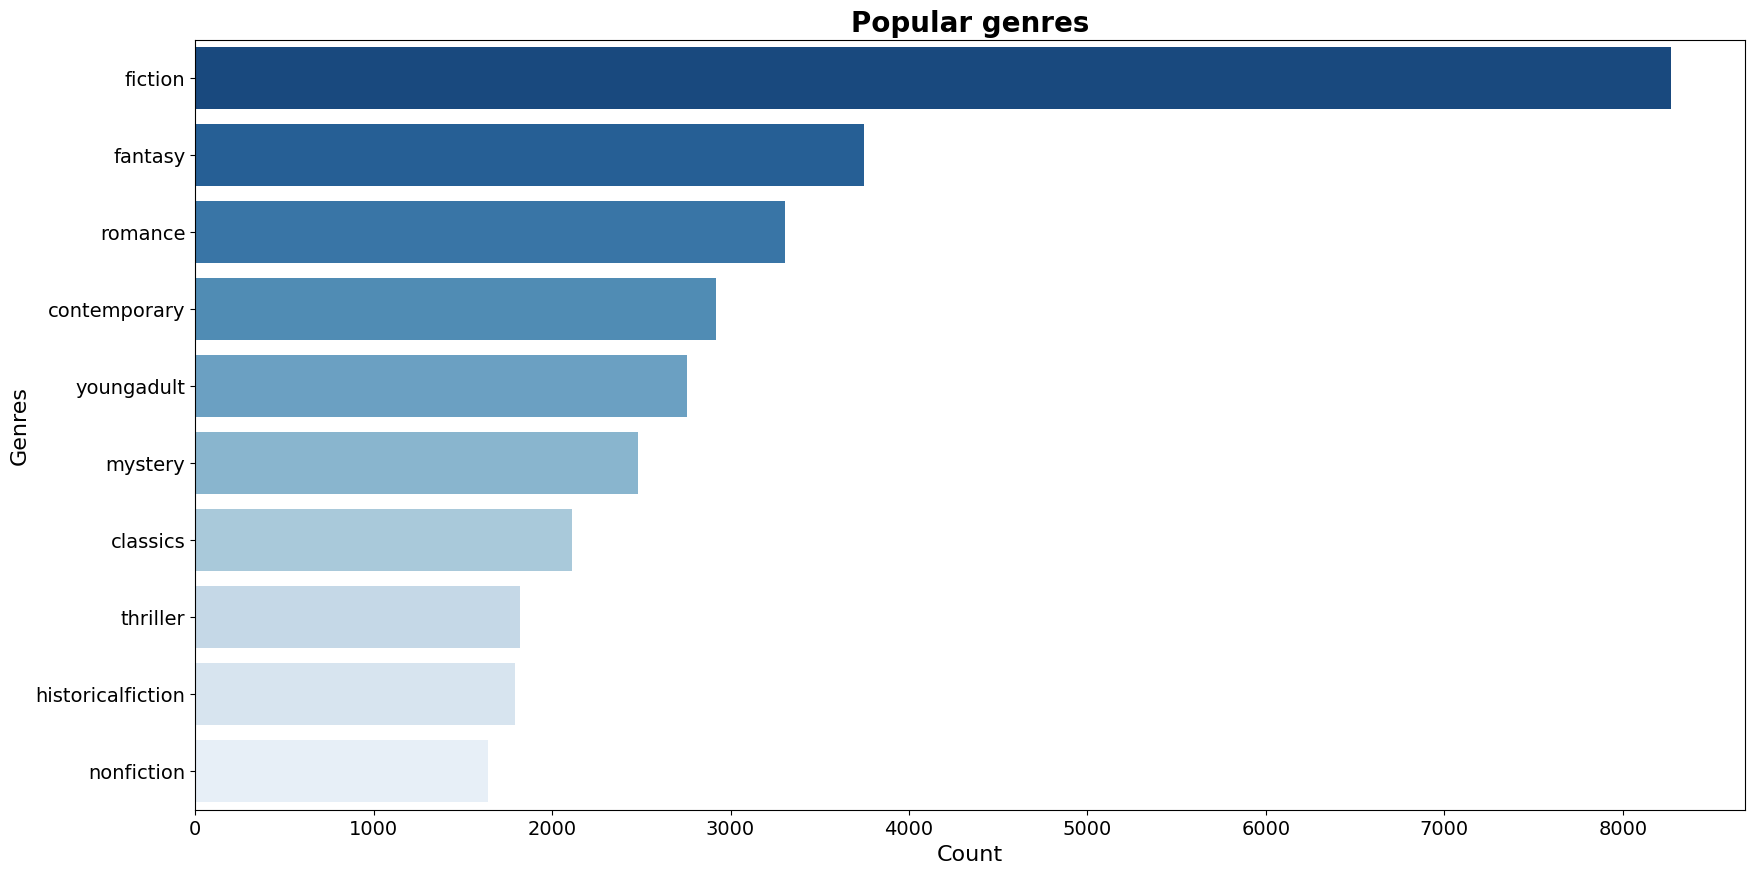

In [87]:
x = book_genres['genres']
y = book_genres['average_rating']

#rank the genre based on number of books
genres_rank = book_genres.genres.value_counts()

#visualize
plt.figure(figsize=(20,10))
sns.barplot(x=genres_rank.head(10).values,
            y=genres_rank.head(10).index,
            palette = 'Blues_r')
plt.title('Popular genres', weight='bold', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

We can see that the majority (around 80%) of the books here are included in fiction books. The second rank goes to fantasy followed by romance. The difference between the first and second ranks is more than half. If you use a filtering method based on genre similarities, it is very unlikely that the engine will recommend non-fiction books.

## Export Data

In [88]:
b.to_csv('data/books_cleaned.csv')